In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import rgb2hex
import data_processing as data
import svg_utils
from pathlib import Path
import glob
import os
import pandas as pd

In [2]:
data_path = Path('./data/raw/allen_HBA')

In [3]:
def read_expression_file(file_name):
    expression_df = pd.read_csv(file_name, index_col=0, header=None)
    expression_df.index.rename('probe_id', inplace=True)
    return expression_df


def read_samples_file(samples_file):
    sample_df = pd.read_csv(samples_file)
    sample_df.set_index(sample_df.index+1, inplace=True)
    sample_df.index.rename('sample_id', inplace=True)
    return sample_df


def get_probes_data(probes_file, probes_strategy='default'):
    strats = ['default', 'reannotator', 'qc_filter', 'qc_scale']
    assert probes_strategy in strats

    # depending on strategy, may merge in diff tables to update probes info
    probes_df = pd.read_csv(probes_file)

    # rename columns for consistency between adult and fetal brain datasets
    if 'probeset_name' in probes_df.columns:
        probes_df.rename(columns={'probeset_name': 'probe_name',
                                  'probeset_id': 'probe_id'}, inplace=True)
    cols = ['probe_id', 'probe_name', 'gene_symbol']
    probes_df = probes_df.loc[:, cols]

    if probes_strategy == 'reannotator':
        reannotations = get_probe_reannotations('./data/raw/gene_symbol_annotations/AllenInstitute_custom_Agilent_Array.txt')
        # drop the original gene_symbol column
        probes_df.drop('gene_symbol', axis=1, inplace=True)
        # merge in the reannotated gene_symbols
        probes_df = probes_df.merge(reannotations, on='probe_name')

    elif probes_strategy in ['qc_filter', 'qc_scale']:
        qc_filt = get_probe_qc_filter('./data/raw/gene_symbol_annotations/12864_2013_7016_MOESM8_ESM.xlsx')
        probes_df = probes_df.merge(qc_filt, left_on='probe_name', right_on='probe')
        probes_df = probes_df[probes_df.qc_filter == True]
        assert is_numeric_dtype(probes_df.m)
        assert is_numeric_dtype(probes_df.b)

        print('After getting probes_df which merged qc data, shape is {}'.format(probes_df.shape))

    probes_df.set_index('probe_id', inplace=True)

    return probes_df


def get_donor_data(donor_file_list, probes_strategy):
    # to work with both fetal and adult metadata
    probe_file_strings = ['Probes', 'rows_meta']
    samples_file_strings = ['Sample', 'columns_meta']
    expression_file_strings = ['Expression', 'expression']

    for file in donor_file_list:
        if any(string in file for string in probe_file_strings):
            probes_df = get_probes_data(file, probes_strategy=probes_strategy)
        elif any(string in file for string in samples_file_strings):
            samples_df = read_samples_file(file)
        elif any(string in file for string in expression_file_strings):
            exp_df = read_expression_file(file)
        else:
            continue

    return exp_df, samples_df, probes_df

def get_mean_expression_by_brain_area(exp_df, samples_df):
    assert(exp_df.T.shape[0] == samples_df.shape[0])

    # merge in metadata (brain area of sample)
    annotated_df = exp_df.T.merge(samples_df[['structure_name']],
                                  left_index=True, right_index=True)

    # get mean expression level for samples within a brain area
    expression_by_structure = annotated_df.groupby('structure_name').mean()
    expression_by_structure.T.index.rename('gene_symbol', inplace=True)

    return expression_by_structure.T


def get_exp_by_genes(exp_df, probes_df):
    """
    input is exp_df and probes metadata is exp_df grou
    outputped by gene_symbols and averaged
    """
    annotated_df = exp_df.merge(probes_df[['gene_symbol']],
                                left_index=True, right_index=True)

    exp_by_genes = (annotated_df.groupby('gene_symbol')
                                .mean())
                                # .drop('na'))
    return exp_by_genes

def strip_left_right(structure_name):
    brain_area_fragments = structure_name.split(',')
    clean_fragments = []

    for frag in brain_area_fragments:
        if frag.strip() not in ['left', 'right', 'Left', 'Right']:
            clean_fragments.append(frag)

    clean_structure_name = ','.join(clean_fragments)
    return clean_structure_name

In [4]:
hba_donor_folders = glob.glob(os.path.join(data_path, '*'))
all_donors = []
for i, donor_folder in enumerate(hba_donor_folders):
    print(f'Processing donor #{i+1}')
    donor_id = donor_folder.split('/')[-1].split('_')[-1]
    print(f'Donor ID: {donor_id}')
    donor_files = glob.glob(os.path.join(donor_folder, '*'))
    expression, samples, probes = get_donor_data(donor_files,
                                                 probes_strategy='default')
    donor_gene_exp = get_exp_by_genes(expression, probes)
    samples.structure_name = samples.structure_name.apply(strip_left_right)
    # this takes mean of gene expression from different brain structures
    # an alternative way to try doing it is by concatenating all samples (from all donors) 
    # and average the final values
    exp_by_brain_area = get_mean_expression_by_brain_area(donor_gene_exp, samples)
    donor_expression  = exp_by_brain_area.T
    all_donors.append(donor_expression)

Processing donor #1
Donor ID: donor10021
Processing donor #2
Donor ID: donor9861
Processing donor #3
Donor ID: donor14380
Processing donor #4
Donor ID: donor15697
Processing donor #5
Donor ID: donor15496
Processing donor #6
Donor ID: donor12876


In [5]:
all_brain_areas = pd.concat(all_donors)

In [6]:
exp_by_area = all_brain_areas.groupby('structure_name').mean()

In [7]:
exp_by_area.shape

(232, 29131)

In [8]:
### NB: ASIC1 gene goes by its old name of ACCN2 in this dataset
###     ASIC2 gene goes by its old name of ACCN1 in this dataset

# there are 232 expression values for ASIC1 
# need to create a lookup table that 
exp_by_area.loc[:, 'ACCN1'].reset_index().rename(columns={'structure': 'expression', 'structure_name': 'structure'})

,structure,ACCN1
0,CA1 field,7.493149
1,CA2 field,8.097968
2,CA3 field,7.717457
3,CA4 field,7.424639
4,"Crus I, lateral hemisphere",6.962618
5,"Crus I, paravermis",6.980468
6,"Crus II, lateral hemisphere",6.990170
7,"Crus II, paravermis",7.059228
8,Edinger-Westphal nucleus,7.228203
9,Heschl's gyrus,7.098749


In [9]:
# %load modify_svg.py
import data_processing as data
import HBA_analysis as hba
import svg_utils
import glob
from pathlib import Path


# define the SVGs files you want to modify


# inputs
svg_dir = Path('./data/svg')
human_diagram = svg_dir / 'human_diagram.svg'
#adult_dir = svg_dir / 'slices' / 'adult'

# define output directory
figures_dir = Path('./figures/ASIC2')
figures_dir.mkdir(exist_ok=True)



In [10]:
def make_expression_lookup(exp_by_area, gene_symbol='GABRA5'):
    # modify the default ontology to remove left/right from structure names
    ontology_df = pd.read_csv('./data/raw/allen_HBA/normalized_microarray_donor10021/Ontology.csv')
    # name column to be the same as fetal ontology
    ontology_df['structure_name'] = ontology_df.name.apply(data.strip_left_right)
    
    # create dicts that map from sID to structure names and inverse
    sID_to_brainstructure = ontology_df.set_index('id').loc[:, 'structure_name'].to_dict()
    brainstructure_to_sID = {}
    for k, v in sID_to_brainstructure.items():
        brainstructure_to_sID[v] = brainstructure_to_sID.get(v, [])
        brainstructure_to_sID[v].append(k)

    # map sIDs to results table
    results = exp_by_area.loc[:, gene_symbol].reset_index().rename(columns={'structure': 'expression', 'structure_name': 'structure'})
    #results = hba.generate_stats_table(exp_df, gene_list)
    #results = results.reset_index()
    #results = results.rename(columns={'index': 'structure'})
    results['id'] = results.structure.map(brainstructure_to_sID)

    # expand rows where there are multiple sIDs for each structure, then merge results
    expression_lookup = results.set_index('structure').id.apply(pd.Series).stack().reset_index(level=1, drop=True)
    #HBA_lookup = HBA_lookup.reset_index(name='id').merge(ontology_df[['id', 'parent_structure_id']], on='id')
    expression_lookup = expression_lookup.reset_index(name='id').merge(ontology_df[['id']], on='id')
    expression_lookup = expression_lookup.merge(results.drop('id', axis=1), on='structure')

    return expression_lookup    

In [11]:
expression_lookup = make_expression_lookup(exp_by_area, 'ACCN1')

In [12]:
expression_lookup.rename(columns={'ACCN1': 'expression'}, inplace=True)

In [13]:
expression_lookup.head()

,structure,id,expression
0,CA1 field,12892,7.493149
1,CA1 field,4254,7.493149
2,CA1 field,4263,7.493149
3,CA2 field,12893,8.097968
4,CA2 field,4255,8.097968


In [14]:
## this is probably unneeded
def convert_to_hex(values, cmap, norm):
    # helper to be applied on lookup table expression values
    cmap = plt.cm.get_cmap(cmap)
    color = cmap(norm(values))
    hex_color = rgb2hex(color)
    
    return hex_color

### START HERE

In [15]:
# probably do not need to add hex color into lookup table
# generate column with hex colour based off of range of expression values
norm = mpl.colors.Normalize(vmin=min(expression_lookup.expression), vmax=max(expression_lookup.expression))
expression_lookup['hex_color'] = expression_lookup.expression.apply(convert_to_hex, cmap='coolwarm', norm=norm)

In [16]:
expression_lookup.head()

,structure,id,expression,hex_color
0,CA1 field,12892,7.493149,#f49a7b
1,CA1 field,4254,7.493149,#f49a7b
2,CA1 field,4263,7.493149,#f49a7b
3,CA2 field,12893,8.097968,#e67259
4,CA2 field,4255,8.097968,#e67259


## After creating expression lookup
1. get sIDS in SVG
2. get_expression_for_sIDs()
3. modify_structure_color()

In [17]:
import json
import os
import requests

def get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10):
    if os.path.exists(json_file):
        with open(json_file) as data_file:
            ontology = json.load(data_file)
    else:
        query_url = "http://api.brain-map.org/api/v2/structure_graph_download/{}.json".format(graph_id)
        r = requests.get(query_url)
        response = r.json()
        ontology = response['msg'][0]
        # dump out the ontology to a file
        with open(json_file, 'w') as outfile:
            json.dump(ontology, outfile)

    return ontology

In [18]:
import xml.etree.ElementTree as ET


def find_structure(self, attr, value):
    # function to find structure in ontology by attribute
    if self[attr] == value:
        return self
    else:
        for child in self['children']:
            match = find_structure(child, attr, value)
            if match:
                return match


def get_sIDs_in_SVG(svg_filename, ontology):
    # function to parse SVG and return a dict with sID as key and value is structure_name
    ns = {'svg':'http://www.w3.org/2000/svg'}
    structures_names = {}

    with open(svg_filename, 'r') as svg:
            doc = ET.parse(svg)
            root = doc.getroot()

            for elem in root.iter():
                # if this is path element and it has a structure_id
                # add structure_id to structures dictionary if it doesn't already exist
                if elem.tag == '{%s}%s' % (ns['svg'], 'path'):
                    if 'structure_id' in elem.attrib:
                        s_id = int(elem.attrib['structure_id'])
                        # is there a need for structures_names dict? would a list of sIDs suffice?
                        # could remove the need for ontology in the function if simply append s_id to a list
                        if s_id not in structures_names:
                            srec = find_structure(ontology, 'id', int(s_id))
                            structures_names[s_id] = srec['name']
    return structures_names


In [19]:
ontology = get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10)

In [20]:
svg_sIDs = get_sIDs_in_SVG(human_diagram, ontology)

In [21]:
import numpy as np

def find_children_sID(self, attr, value):
    # function to find structure IDs of the children of a given structure
    children_sID = []
    reduced_onto = find_structure(self, attr, value)
    for child in reduced_onto['children']:
        children_sID.append(child['id'])
    return children_sID


## modified previous rollup function to use expression values instead of AUC values

def roll_up(sID_list, ontology, expression_lookup, exp_vals=None):
    if exp_vals is None:
        exp_vals = []
    for sID in sID_list:
        # if the structure with sID is found in HBA_lookup
        if expression_lookup[expression_lookup.id == float(sID)].shape[0] > 0:
            #value = float(expression_lookup[expression_lookup.id == float(sID)].loc[:,'expression'])
            value = float(expression_lookup[expression_lookup.id == sID].loc[:,'expression'])
            exp_vals.append(value)
        elif len(find_children_sID(ontology, 'id', sID)) > 0:
            # the sID was not found in the results table
            # get a list of sIDs of the children of the structure of interest
            children_sIDs = find_children_sID(ontology, 'id', sID)
            roll_up(children_sIDs, ontology, expression_lookup, exp_vals)
            #print(f'sID:{sID} not found in table, rolling up values from children structures {children_sIDs}')
        else:
            # the structure was not found in HBA_lookup, nor were any of its children
            # get the values of parent structure

            # get parent sID
            structure_info = find_structure(ontology, 'id', sID)
            parent_sID = structure_info['parent_structure_id']
            print(f'sID: {sID} not found in lookup, getting values from parent: {parent_sID}')
            # get AUC val for that parent sID
            try:
                value = float(expression_lookup[expression_lookup.id == float(parent_sID)].loc[:,'expression'])
                exp_vals.append(value)
            except TypeError:
                print('No children to roll-up AUC values or parent to inherit AUC val from for sID: {}'.format(sID))
                #continue
                 
    return exp_vals


def get_exp_vals_for_sIDs(sIDs, ontology, expression_lookup):
    exp_vals = {}

    for sID in sIDs:
        children_exp_vals = roll_up([sID], ontology, expression_lookup)
        exp_vals[sID] = np.mean(children_exp_vals)

    return exp_vals

In [22]:
sID_exp_map = get_exp_vals_for_sIDs(svg_sIDs.keys(), ontology, expression_lookup)

sID: 9625 not found in lookup, getting values from parent: 9624
No children to roll-up AUC values or parent to inherit AUC val from for sID: 9625
sID: 9626 not found in lookup, getting values from parent: 9624
No children to roll-up AUC values or parent to inherit AUC val from for sID: 9626
sID: 9205 not found in lookup, getting values from parent: 9204
No children to roll-up AUC values or parent to inherit AUC val from for sID: 9205
sID: 9212 not found in lookup, getting values from parent: 9211
No children to roll-up AUC values or parent to inherit AUC val from for sID: 9212


In [23]:
import math

def convert_vals_to_hex(sID_val_map, cmap='coolwarm', generate_cbar=False): #'bwr'
    #centered_vals = np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5)
    #drop nans
    #centered_vals = centered_vals[~np.isnan(centered_vals)]
    #extreme_val = max(centered_vals)
    #extreme_val = max(np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5))

    norm = mpl.colors.Normalize(vmin=min(sID_val_map.values()) , vmax=max(sID_val_map.values()))
    color_map = plt.cm.get_cmap('{}'.format(cmap))
    sID_hex_map = {}
    for key, exp_value in sID_exp_map.items():
        #print('AUC: {} and normed: {}'.format(AUC_value, norm(AUC_value)))
        #normalized_value = norm(AUC_value)
        if math.isnan(exp_value):
            colour = '#FFFFFF'
        else:
            colour = color_map(norm(exp_value))

        sID_hex_map[key] = rgb2hex(colour)

    if generate_cbar:
        fig, ax = plt.subplots(figsize=(1, 8))
        cbar = mpl.colorbar.ColorbarBase(ax, cmap=color_map, norm=norm)
                                 #orientation='horizontal')
        cbar.set_label('Expression log2 intensity', size=24, rotation=-90, va='bottom')

        return sID_hex_map, fig

    return sID_hex_map


from bs4 import BeautifulSoup

def modify_structure_color(input_svg_file, sID_val_map, output_file, cbar_file=None):
    # function to modify the colour of a structure in the SVG
    with open(output_file, 'w') as outfile, open(input_svg_file, 'r') as infile:
        # parse the svg file
        soup = BeautifulSoup(infile, 'xml')

        if cbar_file:
            sID_hex_map, cbar = convert_vals_to_hex(sID_val_map, generate_cbar=True)
            #fig.savefig(fname='./figures/colorbar.svg', format="svg")
            print(f'saving colourbar to: {cbar_file}')
            cbar.savefig(filename=cbar_file)

        else:
            sID_hex_map = convert_vals_to_hex(sID_val_map)

        # searches svg file for descendants with the structure_id of interest
        for sID in sID_hex_map:

            for desc in soup.descendants:
                try:
                    attributes = desc.attrs
                    try:
                        # need a special rule for white matter of forebrain
                        if int(attributes['structure_id']) == 9219: # 9219 = sID of telencephalic whitematter
                            attributes['style'] = 'stroke:black;fill:{}'.format('#FFFFFF') #FFC0CB
                        if int(attributes['structure_id']) == sID:
                            #print("found structure of interest: ", sID)
                            #print('structure_id: ', desc['structure_id'])
                            #print(attributes['style'])
                            attributes['style'] = 'stroke:black;fill:{}'.format(sID_hex_map[sID])
                            #print('colouring in with: ', attributes['style'])
                            #print()
                        else:
                            continue
                    except (KeyError, AttributeError):
                        #print('no attributes for this descendant:', desc)
                        continue
                except AttributeError:
                    #print('no stucture attributes for this descendant:', attributes)
                    continue
        print(f'Writing modified svg to {output_file}')
        outfile.write(str(soup))
        #return outfile

In [24]:
modify_structure_color(input_svg_file=human_diagram, sID_val_map=sID_exp_map, output_file='./figures/ASIC2/ASIC2_coolwarm.svg')

Writing modified svg to ./figures/ASIC2/ASIC2_coolwarm.svg


In [25]:
sID_hex_map, cbar = convert_vals_to_hex(sID_val_map=sID_exp_map, cmap='coolwarm', generate_cbar=True)

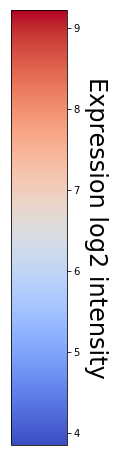

In [26]:
cbar

In [27]:
sID_exp_map

{4010: 7.245855860031686,
 4021: 7.465327206582507,
 4028: 7.120831440767577,
 4038: 7.139018593702493,
 4041: 7.28163143831225,
 4044: 7.179334013060814,
 4047: 7.189655190657145,
 4050: 7.1451303407080475,
 4053: 7.181559626088299,
 4056: 7.450726936748491,
 4059: 7.151885455903627,
 4062: 7.512238705909377,
 4065: 7.514662519757611,
 4068: 7.828451889302002,
 4071: 7.268879206369503,
 4078: 7.234254015492652,
 4085: 7.081610244543795,
 4096: 7.110342881575443,
 4104: 7.164295561276546,
 4111: 7.126352036717296,
 4118: 7.108344559051508,
 4125: 6.986876116530984,
 4133: 7.2124262628235805,
 4140: 7.141336196885749,
 4147: 7.190208970407583,
 4156: 7.280395697680263,
 4165: 7.098748526888683,
 4168: 7.043605411596165,
 4171: 6.972026353866701,
 4174: 7.2981345232817745,
 4177: 7.239959359319773,
 4181: 7.014609301808158,
 4186: 6.855117922796436,
 4187: 6.6954974919246375,
 4193: 6.920049681906982,
 4194: 6.742080082055522,
 4198: 7.036652762058448,
 4205: 7.053789281681848,
 4212: 7.

In [28]:
# modify the default ontology to remove left/right from structure names
ontology_df = pd.read_csv('./data/raw/allen_HBA/normalized_microarray_donor10021/Ontology.csv')
# name column to be the same as fetal ontology
ontology_df['structure_name'] = ontology_df.name.apply(data.strip_left_right)

# create dicts that map from sID to structure names and inverse
sID_to_brainstructure = ontology_df.set_index('id').loc[:, 'structure_name'].to_dict()
brainstructure_to_sID = {}
for k, v in sID_to_brainstructure.items():
    brainstructure_to_sID[v] = brainstructure_to_sID.get(v, [])
    brainstructure_to_sID[v].append(k)


In [29]:
final_table = pd.Series(sID_exp_map).reset_index(name='expression').rename(columns={'index': 'sID'})

In [30]:
final_table['structure'] = final_table.sID.map(sID_to_brainstructure)

In [31]:
final_table.sort_values('expression', ascending=False).to_csv('./figures/ASIC2/ASIC2_expression-HBA.csv', index=None)

In [32]:
# to get the expression values in the 232 aggregated brain areas
expression_lookup.drop(['id', 'hex_color'], axis=1).drop_duplicates().shape

(232, 2)

In [33]:
expression_lookup.drop(['id', 'hex_color'], axis=1).drop_duplicates().sort_values('expression', ascending=False).reset_index()

,index,structure,expression
0,109,basal nucleus of meynert,9.228408
1,251,inferior olivary complex,9.218348
2,351,"nucleus of the diagonal band, horizontal division",8.978382
3,121,caudal group of intralaminar nuclei,8.368238
4,405,piriform cortex,8.266396
5,486,substantia innominata,8.224708
6,483,subiculum,8.203410
7,353,"nucleus of the diagonal band, vertical division",8.151067
8,155,claustrum,8.129900
9,3,CA2 field,8.097968
